### ECG Denoising

We explore normalizing flow as an alternative to diffusion models for ECG signal synthesis (and reconstructions/denoising).

We can use supervised image restoration diffusion models... for reconsturction, but implement in with latent flow. (https://arxiv.org/pdf/2308.09388.pdf)



Imports... If you are missing them, use
-  %pip install library1 library2 .. 

In [3]:
import torch
import torchaudio 
import wfdb
import os
import sys
import matplotlib.pyplot as plt
from wfdb import processing

print('It is working...')
print(sys.prefix)


It is working...
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


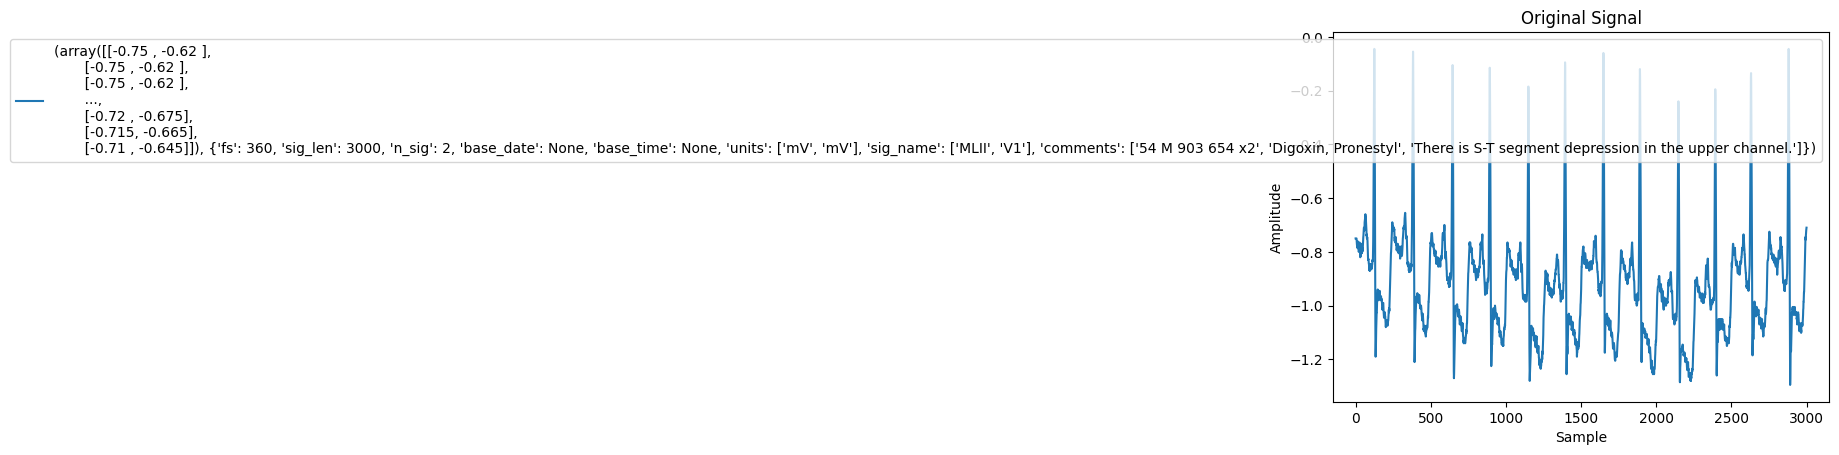

In [4]:

# Path to individual ecg file
# path_102 = "data/nstdb/118e06"
path_102 = "data/ardb/112"

# Extract record
record_102 = wfdb.rdsamp(path_102, sampto=3000)

# Extract Lead I ECG signal
signal_102 = record_102[0][:, 0]

plt.plot(signal_102, label=str(record_102))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.legend()
plt.show()



We proceed to extract the QRS complexes, we can use this to create windows to later build the spectograms.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


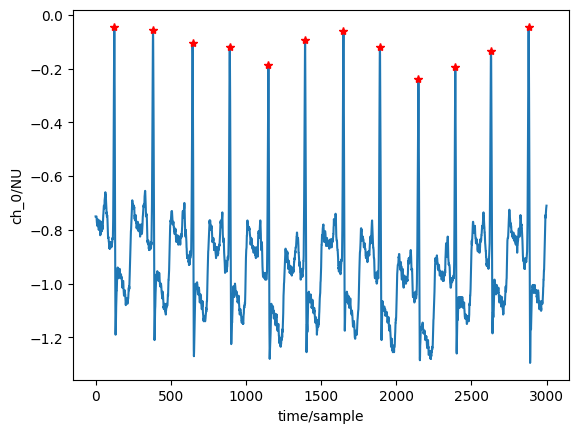

[ 124  382  645  893 1149 1393 1648 1891 2147 2392 2630 2880]


In [5]:
import wfdb
from wfdb import processing

# Load the ECG signal
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Plot the signal with QRS complex annotations
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])

print(xqrs.qrs_inds)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


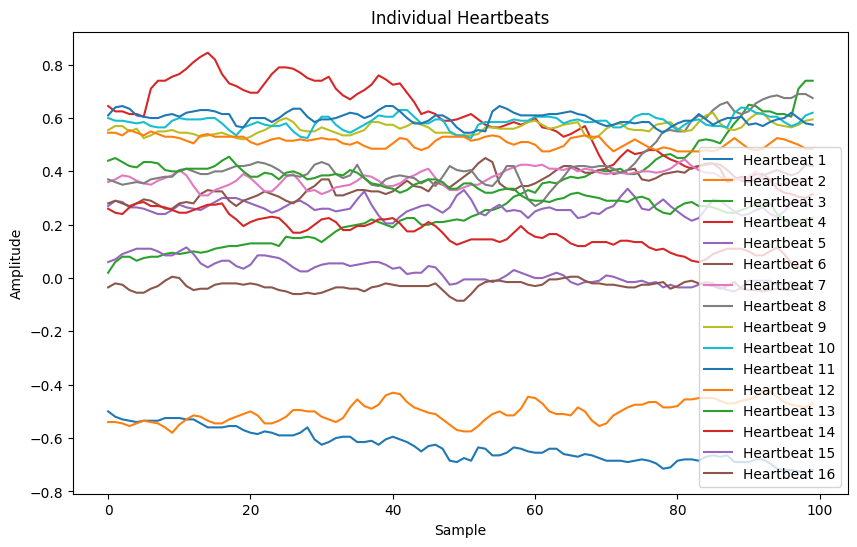

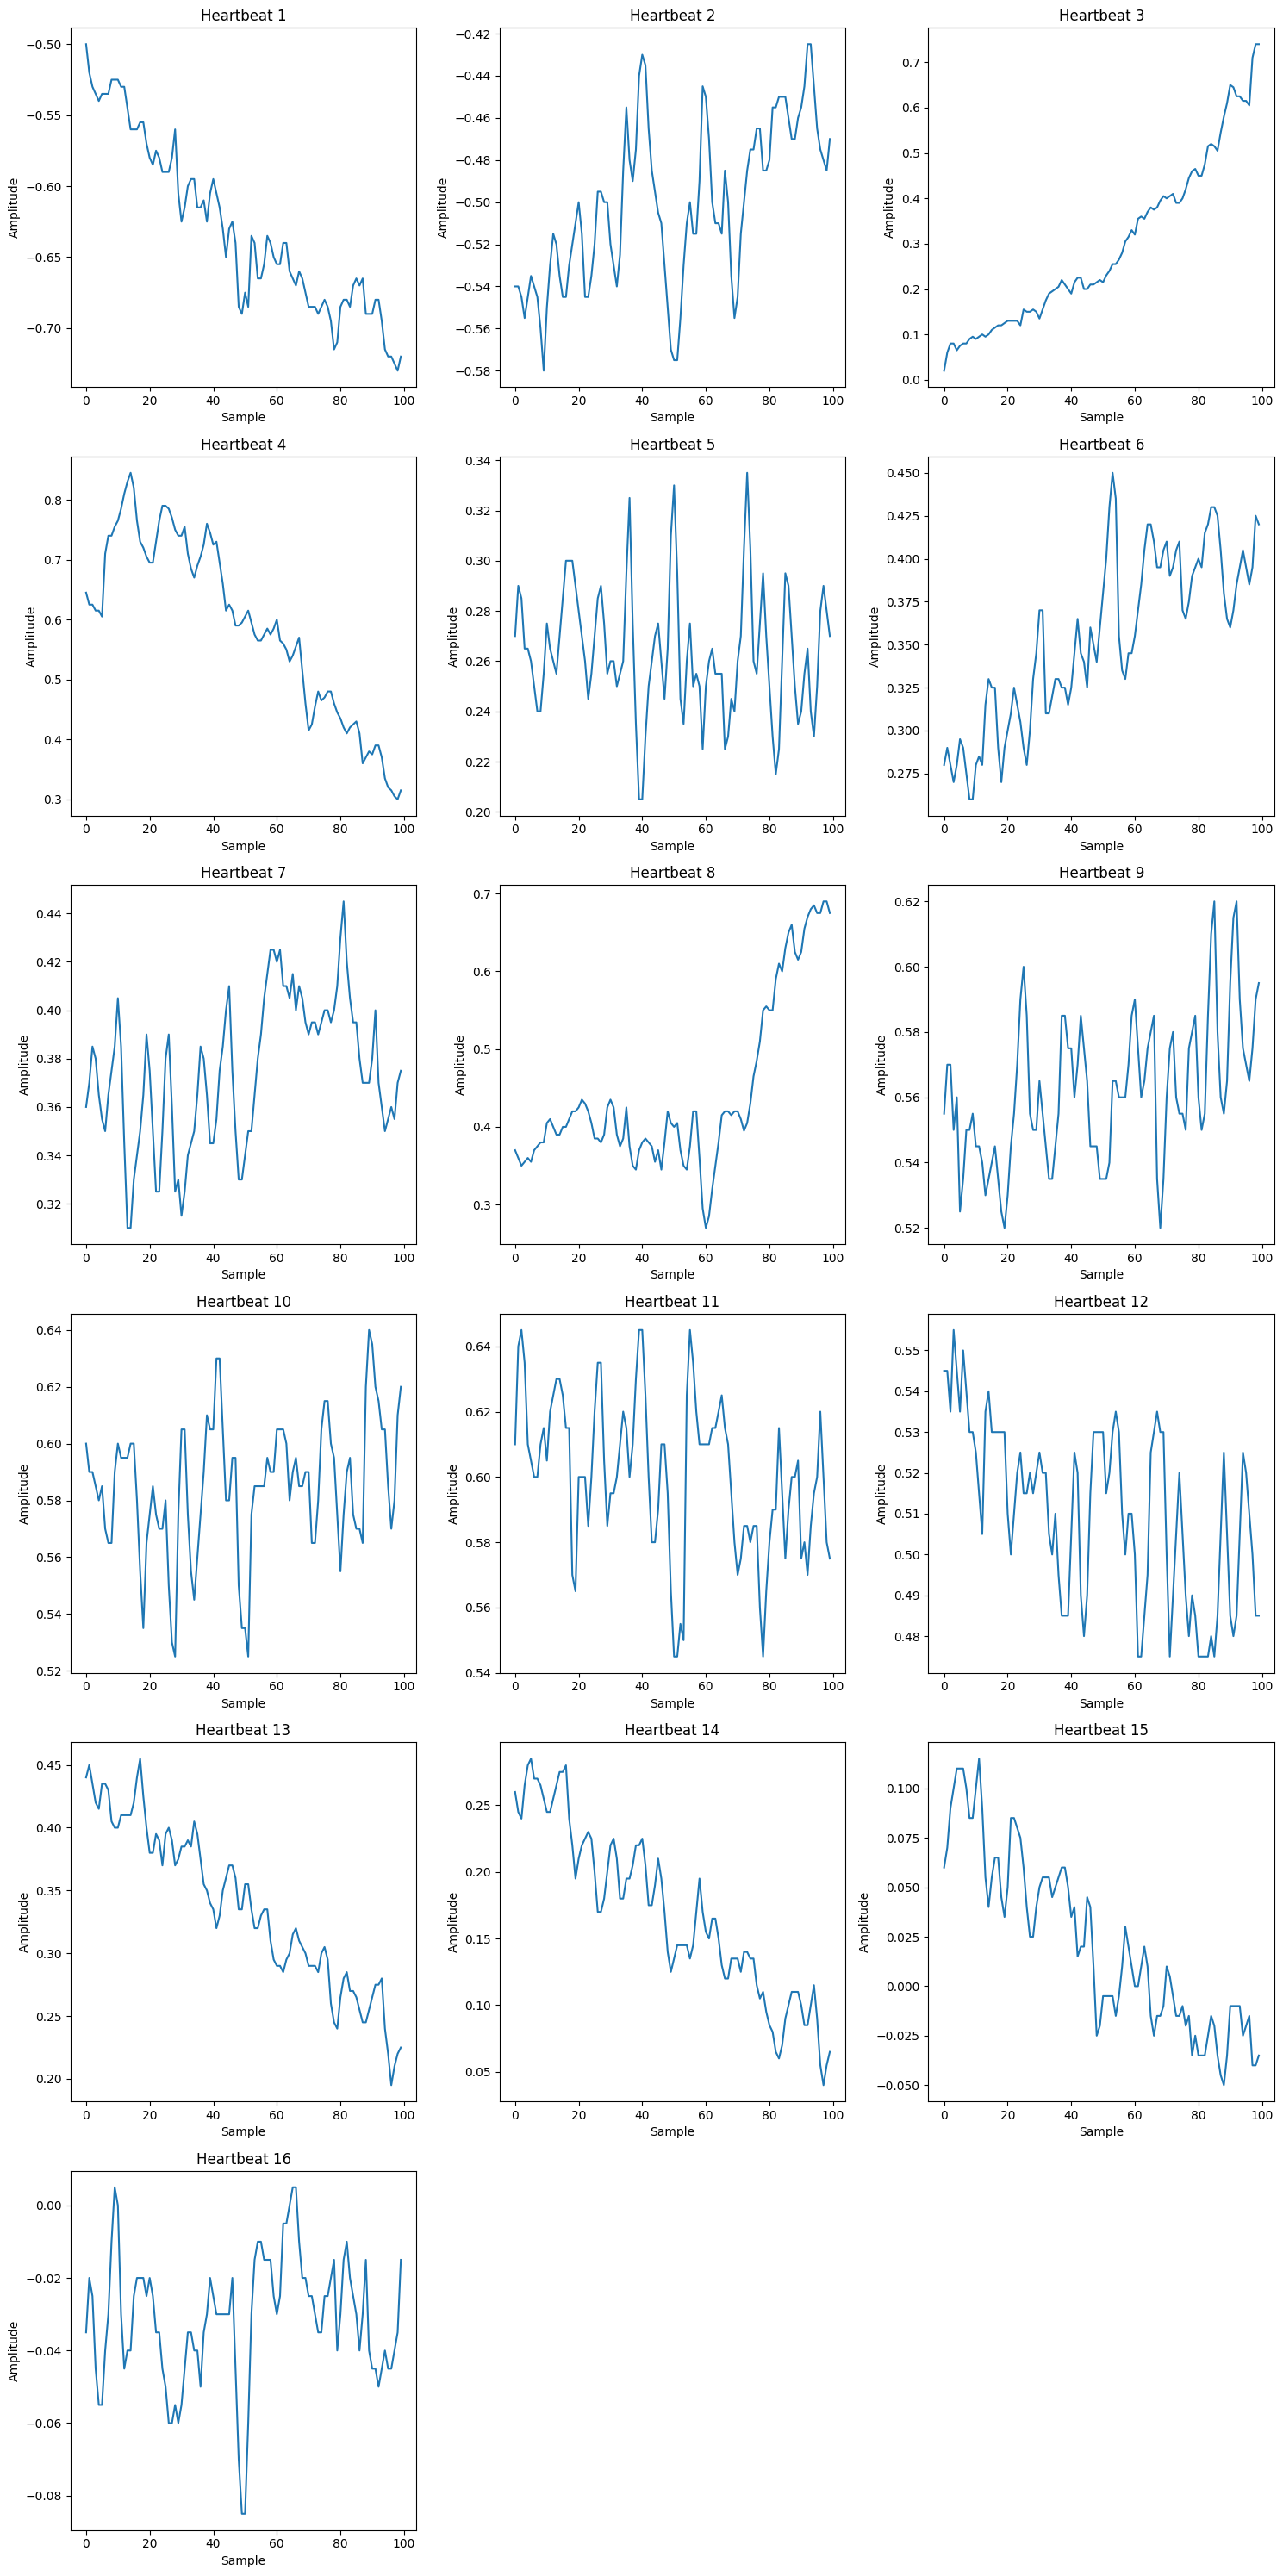

Duration: 8.33 seconds
Average duration of a heartbeat: 0.48 seconds


In [6]:
import wfdb
from wfdb import processing
import numpy as np

# Load the ECG signal
# path_102 = "data/ardb/112"
path_102 = "data/nstdb/bw"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Segment the signal around QRS complexes
window_size = 100  # Define the window size around each QRS complex
heartbeats = []
for qrs_index in xqrs.qrs_inds:
    start_index = max(0, qrs_index - window_size // 2)
    end_index = min(len(sig), qrs_index + window_size // 2)
    heartbeat = sig[start_index:end_index]
    heartbeats.append(heartbeat)

sig = heartbeats[1]

# TODO:
# use pytorchaudio to convert each heartbeat to a spectogram 
# plot the spectograms 

# Plot the individual heartbeats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, heartbeat in enumerate(heartbeats):
    plt.plot(heartbeat, label=f"Heartbeat {i+1}")

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Individual Heartbeats')
plt.legend()
plt.show()

# Plot the individual heartbeats in separate subplots
num_beats = len(heartbeats)
num_cols = 3  # Define the number of columns for subplots
num_rows = (num_beats + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(15, 5*num_rows))
for i, heartbeat in enumerate(heartbeats):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(heartbeat)
    plt.title(f"Heartbeat {i+1}")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Duration
sampling_frequency = 360
num_samples = 3000
duration = num_samples / sampling_frequency

print(f"Duration: {duration:.2f} seconds")

# Calculate the intervals between consecutive QRS complexes
qrs_intervals = np.diff(xqrs.qrs_inds) / fields['fs']  # Convert samples to seconds

# Calculate the average duration of a heartbeat
avg_heartbeat_duration = np.mean(qrs_intervals)

print(f"Average duration of a heartbeat: {avg_heartbeat_duration:.2f} seconds")

This is the step that allows us to actually generate 

Approaches:

1. single heartbeat 
- use of single heartbeat might be interesting for synthesis done by diffusion model approach (https://arxiv.org/pdf/2306.01875.pdf)
- however this would not correctly capture noise types that affect multiple heart beats (I guess especially with real-world data)

2. Sliding Window
- use of a sliding window (fixed 3.0 sec), but might cut of important characteristics (assumption)
- one paper used 3.0 seconds sliding window with 0.5 sec. overlap. (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754)

3. Alternative
- use a fixed number of heartbeats when using training data, however.. then the sliding window varies (therefore, chaning input length to network..)
- or.. take into account average human has heartbeat of approx 0.8 seconds, and base the sliding  window on this

Key: 
- approaches ECG signal denoising as a image restoration problem (work on 2D spectorgrams) and use generative AI strategies (such as super-resolution) to recover/reconstruct the signal.

or for example... what we see when doing audio super resolution using conditional diffusion models: https://arxiv.org/pdf/2104.02321.pdf

Now we can generate some spectograms ..

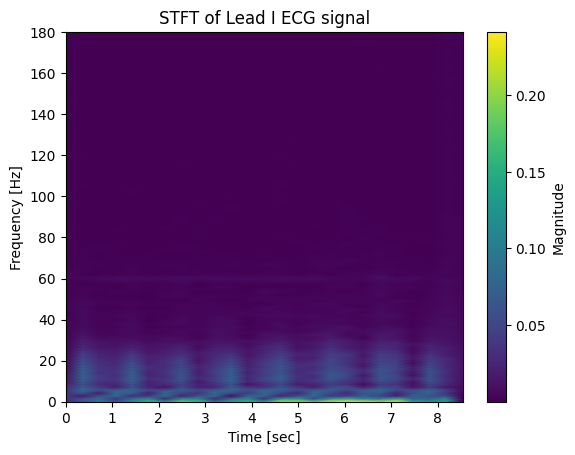

In [15]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import stft

record = wfdb.rdsamp('data/ardb/215', sampto=3000)
I = record[0][:, 0]


# Define parameters
window_size = 2048
hop_length = 512

# Ensure that noverlap is less than nperseg
noverlap = window_size - hop_length

# Perform Short-Time Fourier Transform (STFT) on Lead I ECG signal
f, t, Zxx = stft(I, fs=360)

# Plot STFT
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('STFT of Lead I ECG signal')
plt.colorbar(label='Magnitude')
plt.show()

scales = np.arange(1, 100)
cwt_result, _ = pywt.cwt(I, scales, 'mexh')

# # Plot scalogram
plt.imshow(np.abs(cwt_result), aspect='auto', extent=[0, len(I), scales[-1], scales[0]])
plt.ylabel('Scale')
plt.xlabel('Datapoints')
plt.title('Scalogram')
plt.show()

Ok.. We build intuition on how to work with ECG singals (detect QRS complexes) and find the spectograms!

**Build Training and validation set**: \
Now we will build a larger training set. At this point only from MIT-BIH Arrythmia, similar to (https://arxiv.org/pdf/2306.01875.pdf) - however we can later include a lot more data... and then we can potentially start using larger window, cause we have more data!

In [ ]:
# 

Let us do the following: 
- step 1 : generate synthetic heartbeats using latent flow matching 
- step 2 : adapt this strategy to denoise ECG signals : use supervised IR DM